##### Libraries

In [842]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
import warnings

from warnings import filterwarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
filterwarnings("ignore")

##### Options

In [843]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 350)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
warnings.simplefilter(action="ignore")

##### Defining  Functions

In [844]:
def check_data(dataframe):
    print(20 * "-" + "Information".center(20) + 20 * "-")
    print(dataframe.info())
    print(20 * "-" + "Data Shape".center(20) + 20 * "-")
    print(dataframe.shape)
    print(20 * "-" + "Nunique".center(20) + 20 * "-")
    print(dataframe.nunique())
    print("\n" + 20 * "-" + "The First 5 Data".center(20) + 20 * "-")
    print(dataframe.head())
    print("\n" + 20 * "-" + "The Last 5 Data".center(20) + 20 * "-")
    print(dataframe.tail())
    print("\n" + 20 * "-" + "Missing Values".center(20) + 20 * "-")
    print((dataframe.isnull().sum()).sort_values(ascending=False))
    print("\n" + 40 * "-" + "Describe the Data".center(40) + 40 * "-")
    print(dataframe.describe([0.01, 0.05, 0.10, 0.50, 0.75, 0.90, 0.95, 0.99]).T)


def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
  It returns categorical, numerical and cardinal variables names and quantity
  Parameters
  ----------
  dataframe: dataframe
      the dataframe where we take the variables names
  cat_th: int, float
      class threshold value for variables that are numeric but categorical
  car_th: int, float
      class threshold value for variables that are categorical but cardinal

  Returns
  -------
      cat_cols: list
          Categorical variables list
      num_cols: list
          Numerical variables list
      cat_but_car: list
          List of cardinal variables with categorical view
  Notes
  -----
  cat_cols + num_cols + cat_but_car = total variables
  num_but_cat in cat_cols

  """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    #cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    #num_but_cat = [col for col in dataframe.columns if pd.Series(dataframe[col]).nunique() < cat_th]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    #num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        plt.figure(figsize=(12, 8))
        sns.countplot(x=dataframe[col_name], data=dataframe)
        #plt.xticks(rotation=30)
        plt.show()


def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")


def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.95,0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)


def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")


def correlation_analysis(dataframe, num_cols, target_col):
    """
    This function calculates correlation matrix, visualizes it with a heatmap,
    and computes the correlation of each numeric column with the target column.

    Parameters:
    - dataframe: DataFrame, the dataset
    - num_cols: list of strings, column names of numeric features
    - target_col: string, the target column name

    Returns:
    - None
    """

    # Correlation Matrix
    correlation_matrix = dataframe[num_cols].corr()

    # Visualization
    f, ax = plt.subplots(figsize=[18, 13])
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", ax=ax, cmap="magma")
    ax.set_title("Correlation Matrix", fontsize=20)
    plt.show()

    # Correlation with Target Column
    correlation_with_target = dataframe[num_cols].corrwith(dataframe[target_col]).sort_values(ascending=False)
    print(correlation_with_target)


def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


def outlier_th(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_th(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=1):
        return True
    else:
        return False


def replace_with_thresholds(dataframe, variable, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_th(dataframe, variable, q1, q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def robust_scaler_func(dataframe, num_cols):
    rs = RobustScaler()
    dataframe[num_cols] = rs.fit_transform(dataframe[[num_cols]])
    return dataframe

##### Datasets
Reading datasets

In [845]:
app = pd.read_csv("C:\\Users\\Melis\\Desktop\\vs_projects\\credit_score_classification\\dataset\\application_record.csv")
credit = pd.read_csv("C:\\Users\\Melis\\Desktop\\vs_projects\\credit_score_classification\\dataset\\credit_record.csv")

Checking for duplicated observations

In [846]:
app_control = app.drop("ID", axis=1)
(app_control.duplicated() == 1).sum() # 348472 duplicated observations out of 438557 observations
not_duplicated_app = app[app_control.duplicated() == 0] # Not duplicated observations

Defining customers' age and merging with application data

In [847]:
customer_age = pd.DataFrame(credit.groupby(["ID"])["MONTHS_BALANCE"].agg(min)) 
# Due to 0 is the current month and -1 is the previous month, minimum "MONTHS_BALANCE" observation will result as customer's starting point.

customer_age = customer_age.rename(columns={"MONTHS_BALANCE": "TENURE"}) 
# Renaming "MONTHS_BALANCE" as "TENURE" will describe variable better.

data = not_duplicated_app.merge(customer_age, on="ID", how="inner") 
# We only take in account the customers who has record in "app" and "credit" datasets.

Classifying customers' paying status (0: No risk, 1: Risk) and merging with application data

In [848]:
credit["STATUS"].value_counts()

STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64

Since "X" value in "STATUS" variable means "no loan for that month", we will not consider these values. Nevertheless, for a different calculation method of "STATUS", which means risk, X values would be useful.

In [849]:
credit_risk = credit[credit["STATUS"] != "X"] 

In [850]:
map_status = {"C": 0,
              "0": 0.1,
              "1": 0.2,
              "2": 0.4,
              "3": 0.6,
              "4": 0.8,
              "5": 1}

Due to the absence of labels in this particular case, this aspect holds crucial importance and should be viewed as a critical juncture. Assigning varying weights to payment statuses based on their delays relative to each other assigns a relative penalty to each payment status, essentially establishing a risk value. Instead of employing binary scoring, calculating the mean risk value of each customer by considering their payment history from the beginning to the current point focuses on evaluating customers' entire debt repayment behavior, thereby assessing their loyalty to debt.

In [851]:
credit_risk["STATUS"] = credit_risk["STATUS"].map(map_status)

In [852]:
credit_target = pd.DataFrame(credit_risk.groupby(["ID"])["STATUS"].mean())

In [853]:
credit_target["STATUS"] = credit_target["STATUS"].apply(lambda x: 0 if x < 0.1 else 1)

In [854]:
credit_target = credit_target.rename(columns={"STATUS": "RISK"})

In [855]:
credit_target.value_counts()

RISK
0       22428
1       19021
Name: count, dtype: int64

In [856]:
df = data.merge(credit_target, on="ID", how="inner")

##### Exploratory Data Analysis

In [857]:
check_data(df)

--------------------    Information     --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8876 entries, 0 to 8875
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   8876 non-null   int64  
 1   CODE_GENDER          8876 non-null   object 
 2   FLAG_OWN_CAR         8876 non-null   object 
 3   FLAG_OWN_REALTY      8876 non-null   object 
 4   CNT_CHILDREN         8876 non-null   int64  
 5   AMT_INCOME_TOTAL     8876 non-null   float64
 6   NAME_INCOME_TYPE     8876 non-null   object 
 7   NAME_EDUCATION_TYPE  8876 non-null   object 
 8   NAME_FAMILY_STATUS   8876 non-null   object 
 9   NAME_HOUSING_TYPE    8876 non-null   object 
 10  DAYS_BIRTH           8876 non-null   int64  
 11  DAYS_EMPLOYED        8876 non-null   int64  
 12  FLAG_MOBIL           8876 non-null   int64  
 13  FLAG_WORK_PHONE      8876 non-null   int64  
 14  FLAG_PHONE           8876 n

In [858]:
df.rename(columns={"CODE_GENDER": "gender",
                   "FLAG_OWN_CAR": "own_car",
                   "FLAG_OWN_REALTY": "own_realty",
                   "DAYS_BIRTH": "birthday",
                   "DAYS_EMPLOYED": "employment_date",
                   "FLAG_MOBIL": "own_mobile",
                   "CNT_CHILDREN": "num_child",
                   "AMT_INCOME_TOTAL": "annual_income",
                   "NAME_EDUCATION_TYPE": "education",
                   "NAME_FAMILY_STATUS": "marital_status",
                   "NAME_HOUSING_TYPE": "house_type",
                   "FLAG_EMAIL": "email",
                   "NAME_INCOME_TYPE": "income_type",
                   "FLAG_WORK_PHONE": "work_phone",
                   "FLAG_PHONE": "phone",
                   "CNT_FAM_MEMBERS": "family_size",
                   "OCCUPATION_TYPE": "occu_type",
                   "TENURE": "tenure",
                   "RISK": "risk"
                   }, inplace=True)

Catching categorical and numerical Variables

In [859]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=20, car_th=50)

Observations: 8876
Variables: 20
cat_cols: 15
num_cols: 5
cat_but_car: 0
num_but_cat: 7


In [860]:
num_cols.remove("ID")

Summary for Categorical Variables

        gender  Ratio
gender               
F         5773 65.041
M         3103 34.959
##########################################


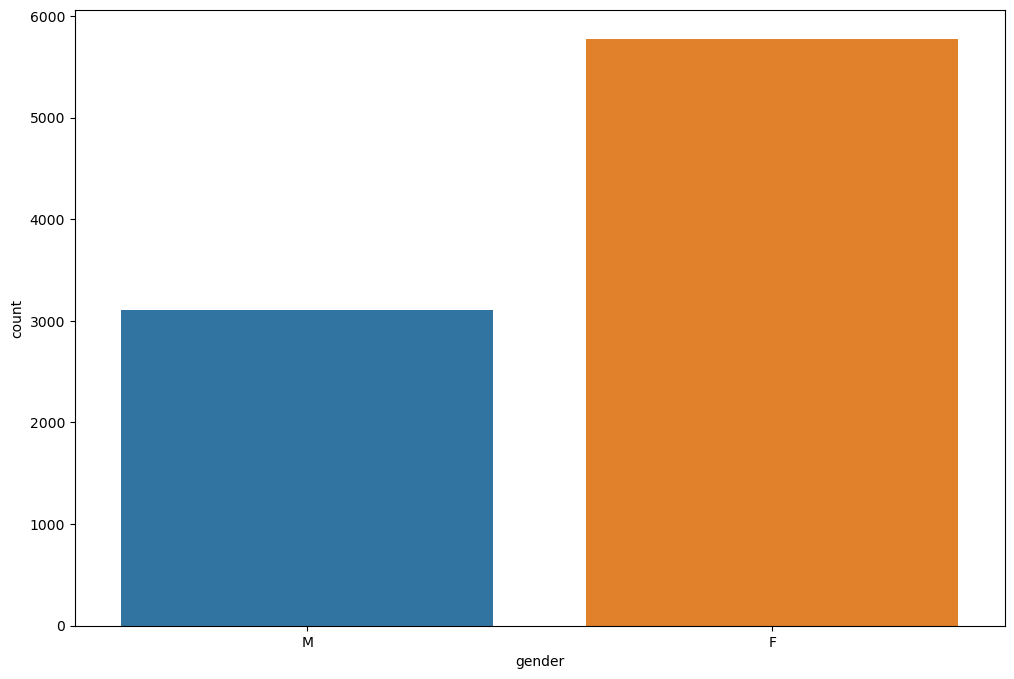

         own_car  Ratio
own_car                
N           5638 63.520
Y           3238 36.480
##########################################


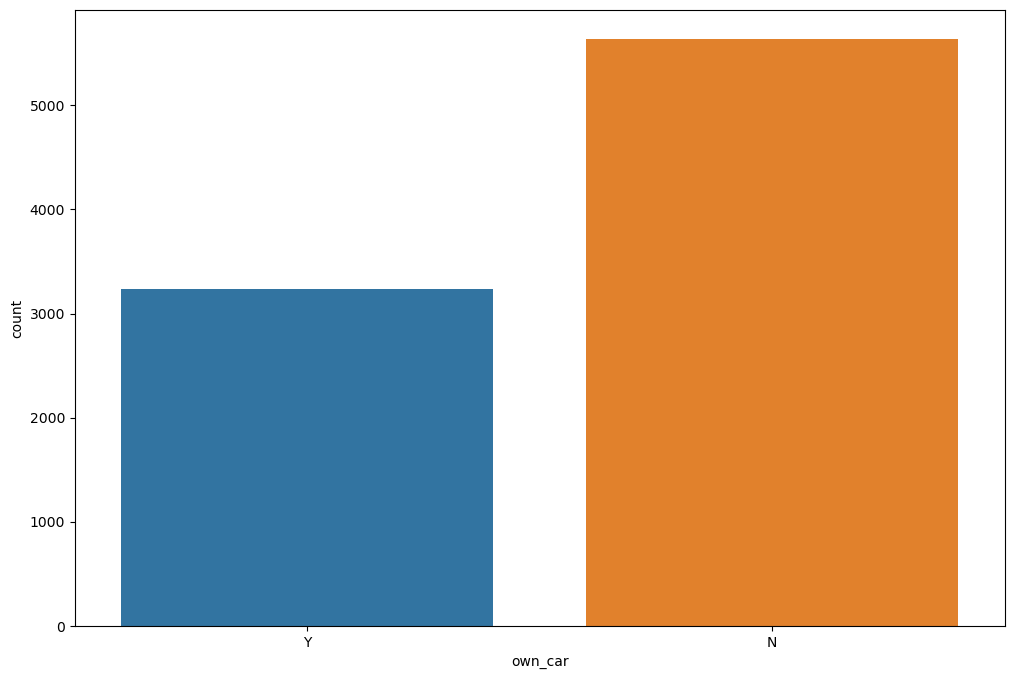

            own_realty  Ratio
own_realty                   
Y                 5988 67.463
N                 2888 32.537
##########################################


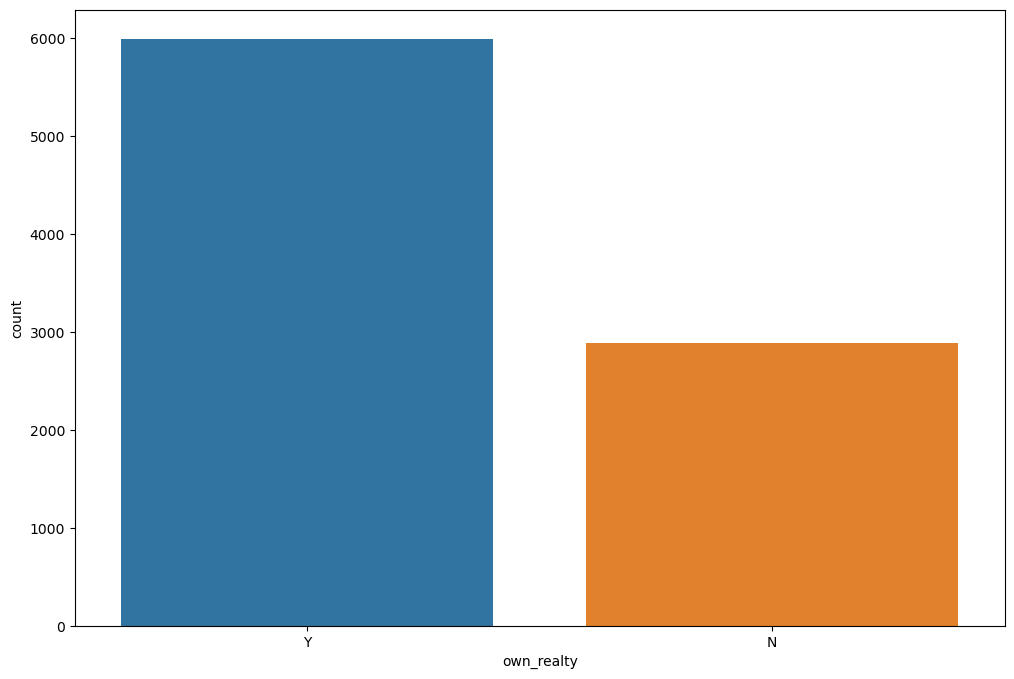

                      income_type  Ratio
income_type                             
Working                      4540 51.149
Commercial associate         2099 23.648
Pensioner                    1578 17.778
State servant                 656  7.391
Student                         3  0.034
##########################################


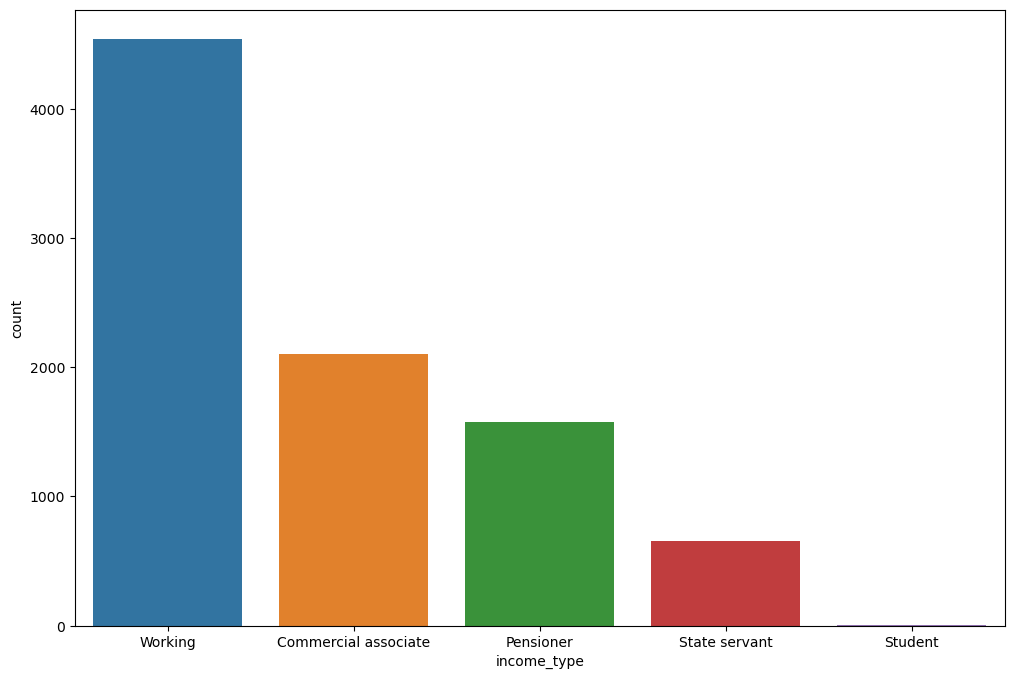

                               education  Ratio
education                                      
Secondary / secondary special       6191 69.750
Higher education                    2235 25.180
Incomplete higher                    342  3.853
Lower secondary                      102  1.149
Academic degree                        6  0.068
##########################################


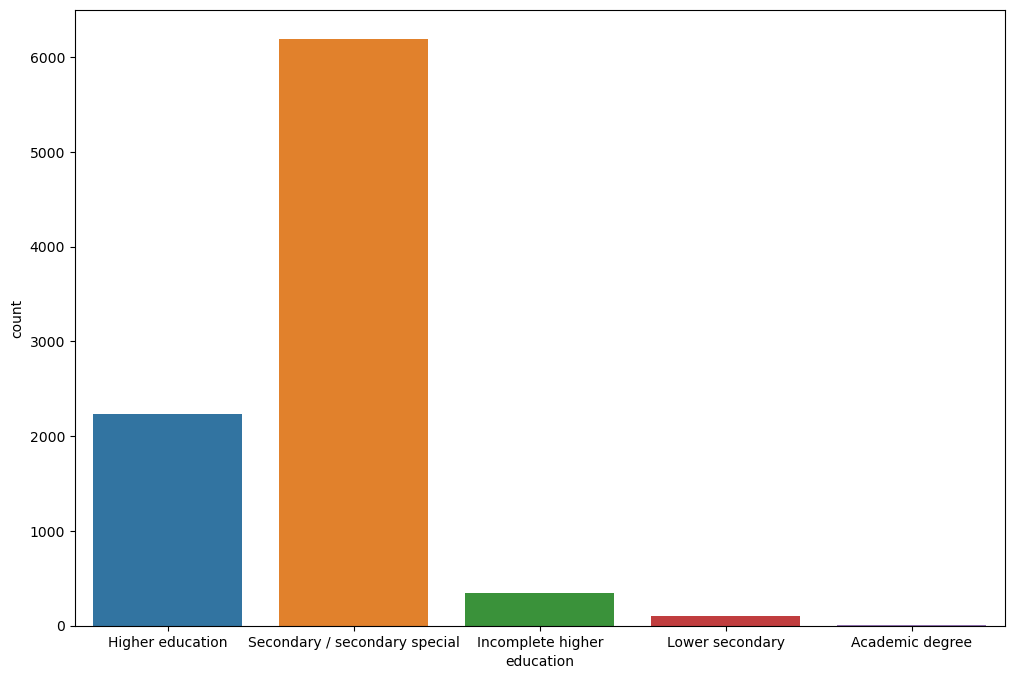

                      marital_status  Ratio
marital_status                             
Married                         5968 67.237
Single / not married            1256 14.151
Civil marriage                   764  8.607
Separated                        525  5.915
Widow                            363  4.090
##########################################


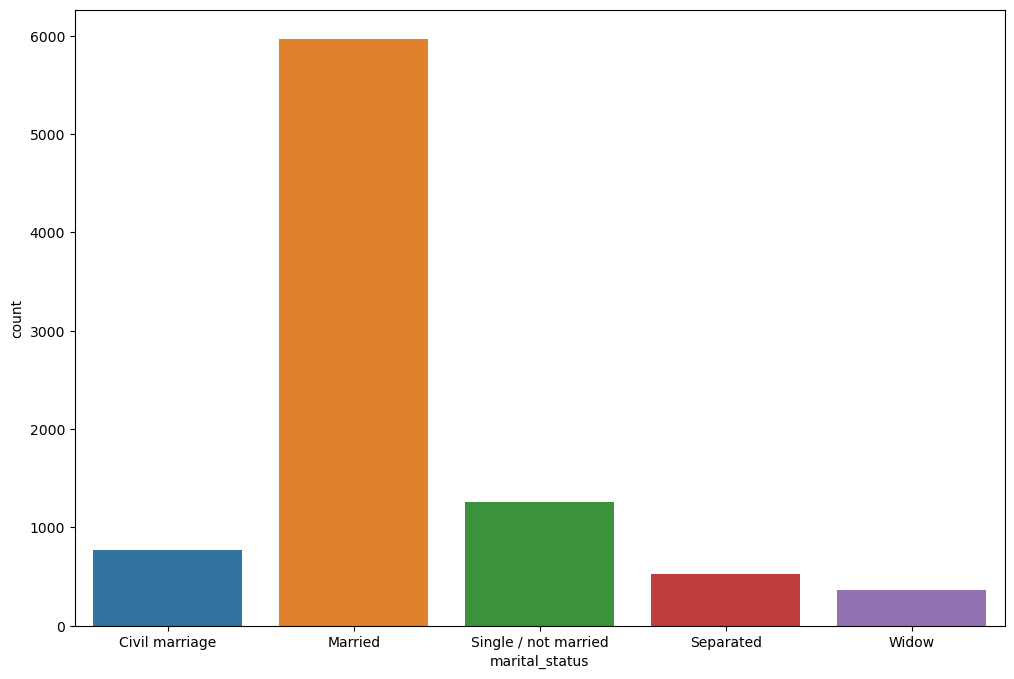

                     house_type  Ratio
house_type                            
House / apartment          7928 89.320
With parents                414  4.664
Municipal apartment         292  3.290
Rented apartment            138  1.555
Office apartment             73  0.822
Co-op apartment              31  0.349
##########################################


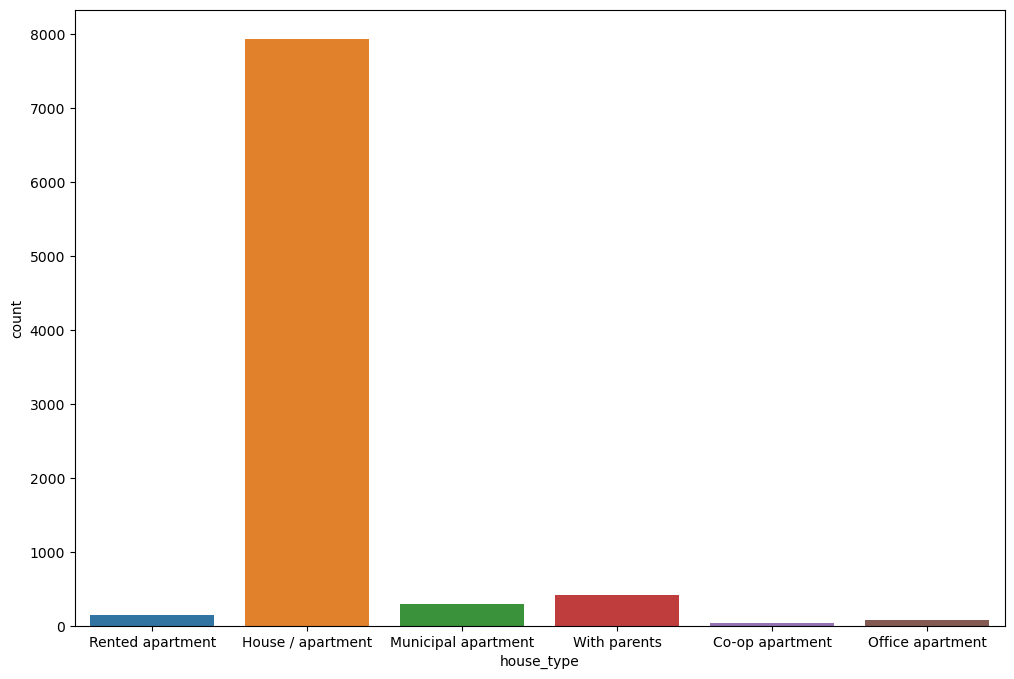

                       occu_type  Ratio
occu_type                              
Laborers                    1560 17.575
Sales staff                  881  9.926
Core staff                   789  8.889
Managers                     706  7.954
Drivers                      567  6.388
High skill tech staff        338  3.808
Medicine staff               274  3.087
Accountants                  273  3.076
Cooking staff                172  1.938
Security staff               164  1.848
Cleaning staff               136  1.532
Private service staff         73  0.822
Low-skill Laborers            49  0.552
Secretaries                   43  0.484
Waiters/barmen staff          37  0.417
HR staff                      22  0.248
IT staff                      18  0.203
Realty agents                 13  0.146
##########################################


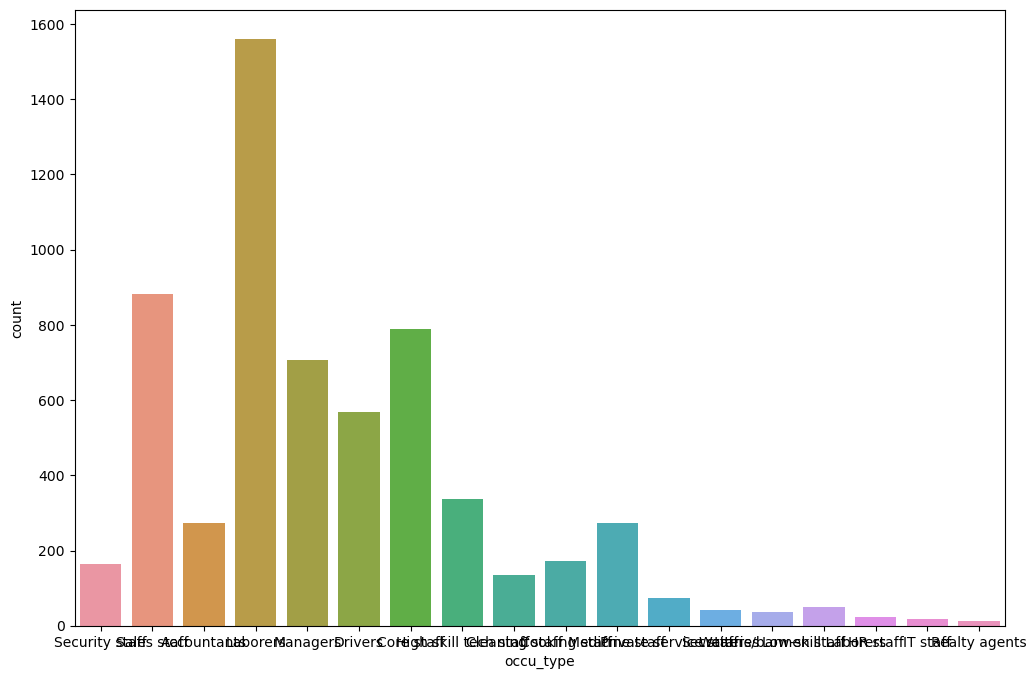

           num_child  Ratio
num_child                  
0               6229 70.178
1               1733 19.525
2                778  8.765
3                113  1.273
4                 16  0.180
5                  4  0.045
14                 1  0.011
19                 1  0.011
7                  1  0.011
##########################################


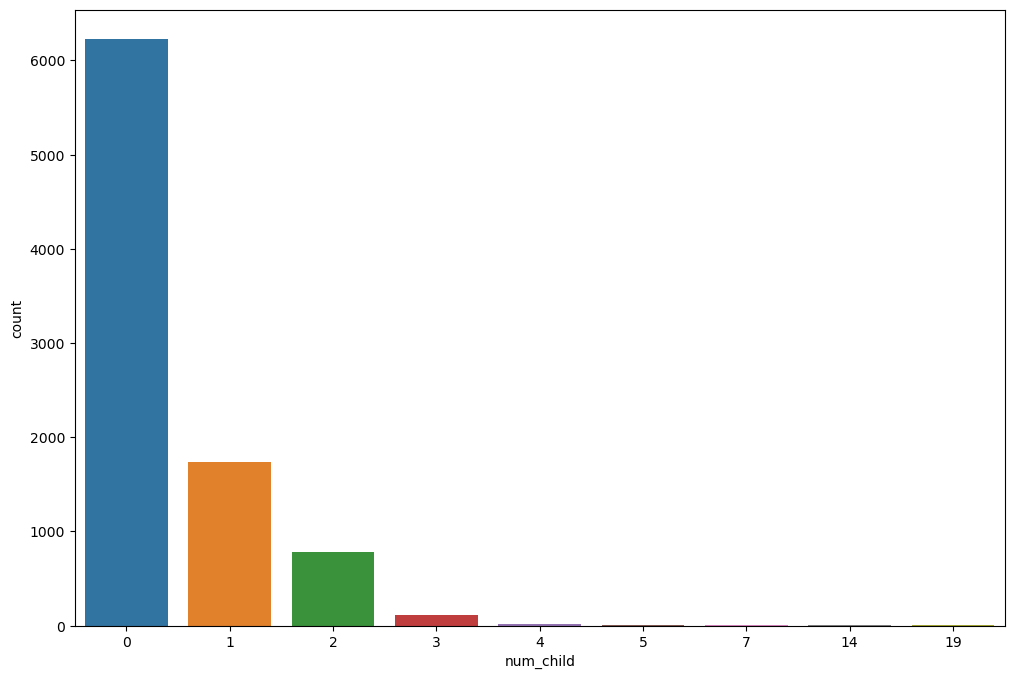

            own_mobile   Ratio
own_mobile                    
1                 8876 100.000
##########################################


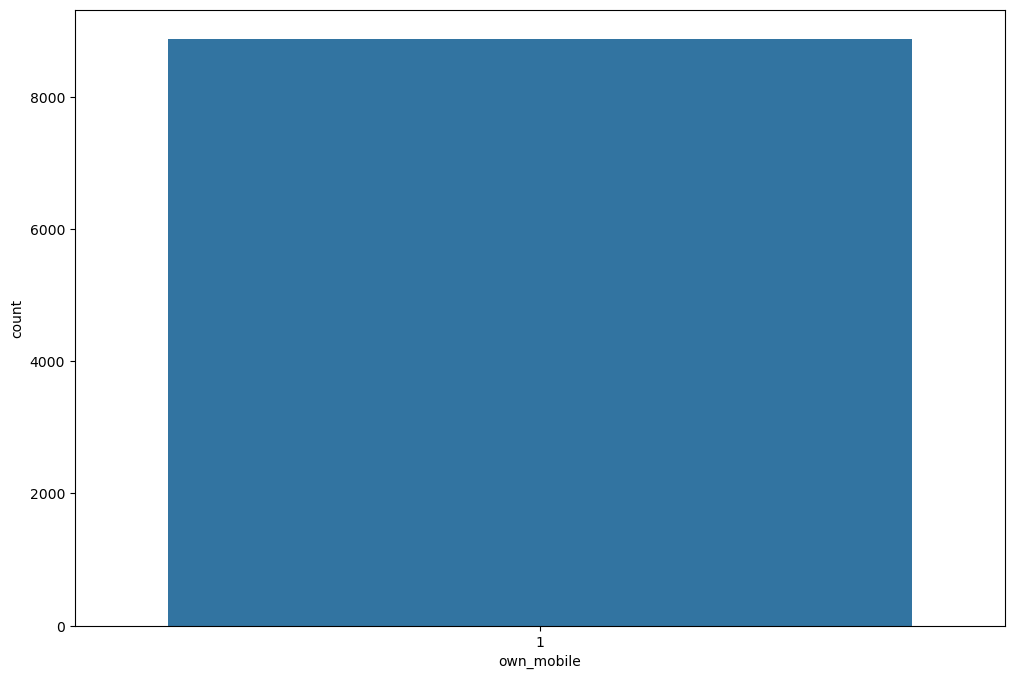

            work_phone  Ratio
work_phone                   
0                 6962 78.436
1                 1914 21.564
##########################################


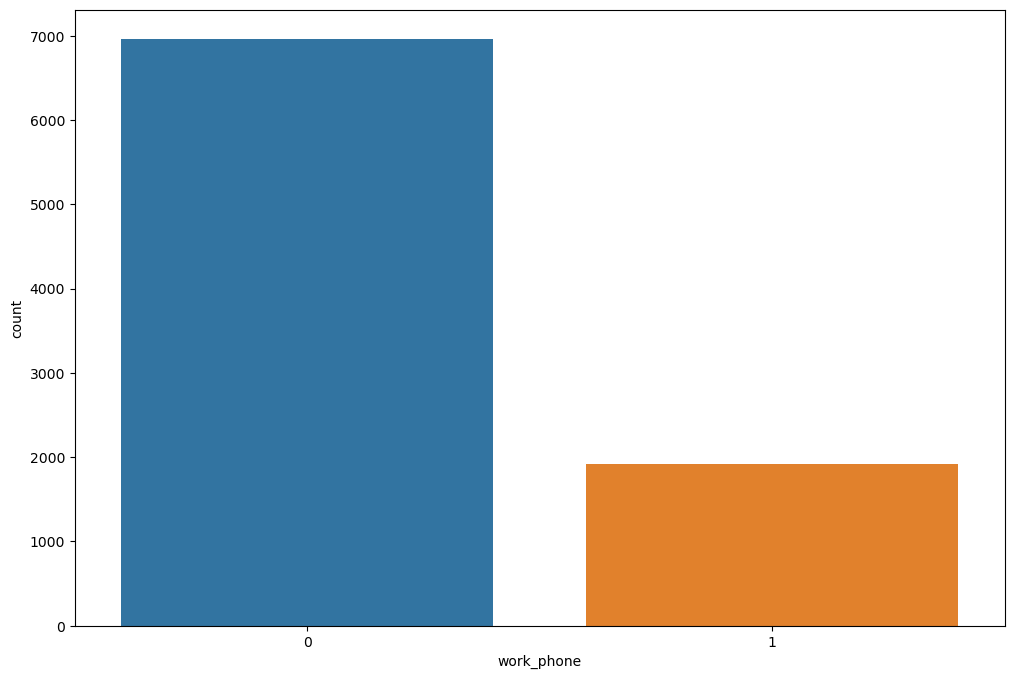

       phone  Ratio
phone              
0       6347 71.507
1       2529 28.493
##########################################


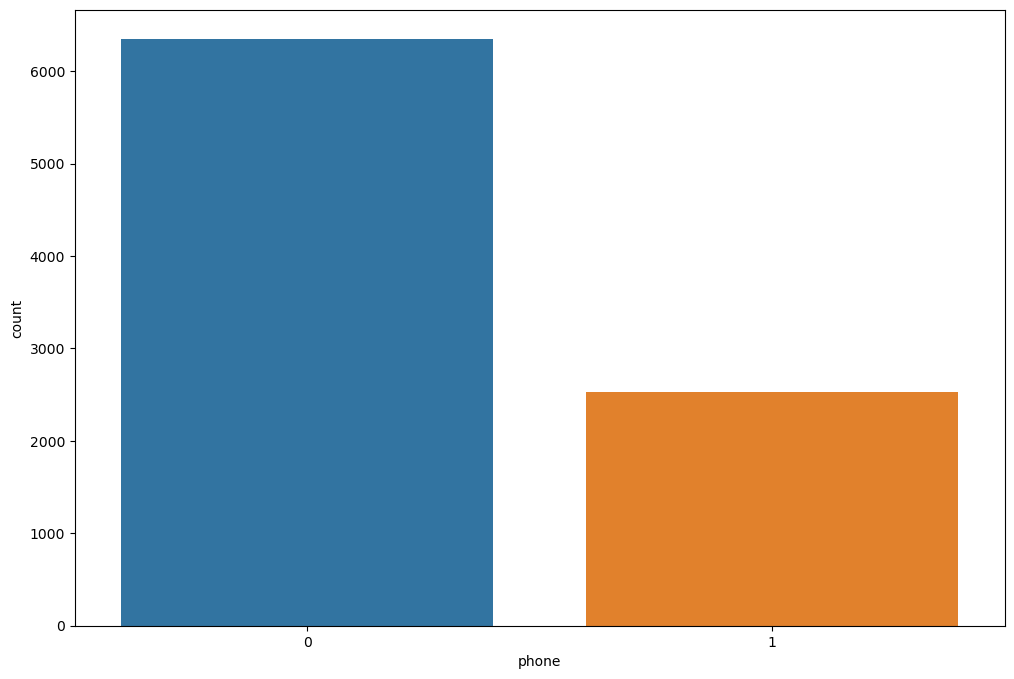

       email  Ratio
email              
0       8110 91.370
1        766  8.630
##########################################


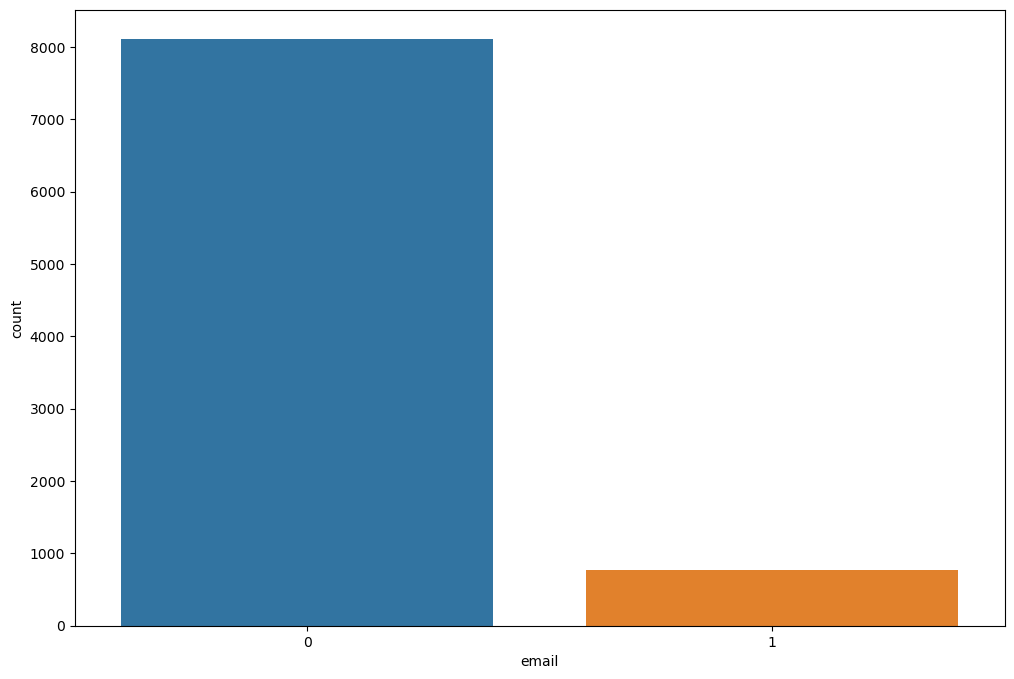

             family_size  Ratio
family_size                    
2.000               4750 53.515
1.000               1773 19.975
3.000               1493 16.821
4.000                733  8.258
5.000                104  1.172
6.000                 17  0.192
7.000                  3  0.034
15.000                 1  0.011
20.000                 1  0.011
9.000                  1  0.011
##########################################


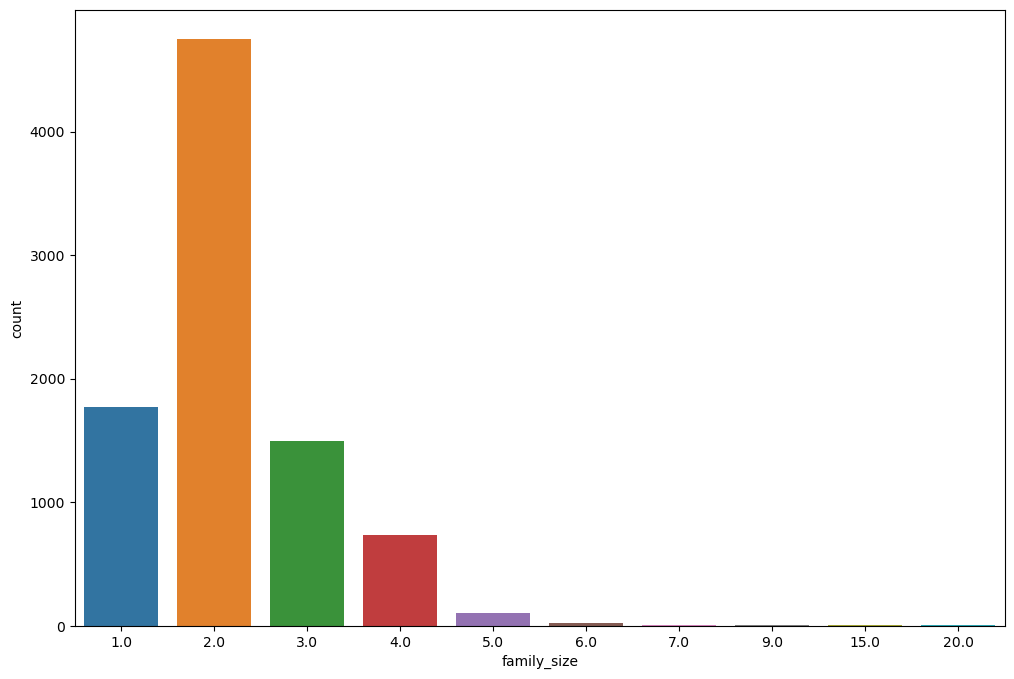

      risk  Ratio
risk             
0     4838 54.507
1     4038 45.493
##########################################


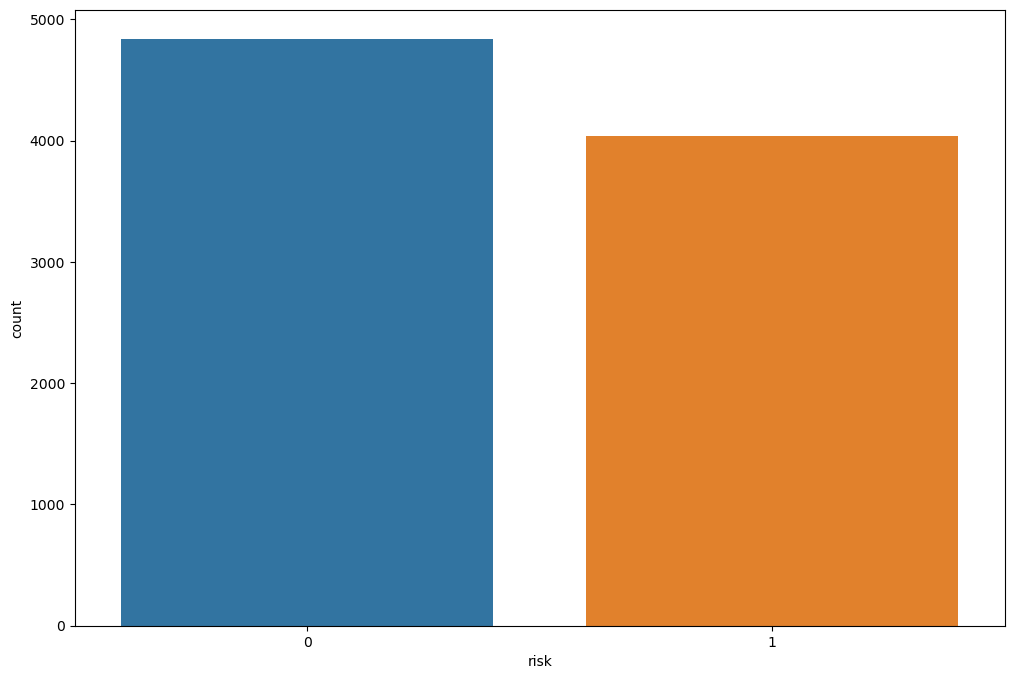

In [861]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

In [862]:
for col in cat_cols:
    target_summary_with_cat(df, "risk", col)

gender
        TARGET_MEAN  Count  Ratio
gender                           
F             0.456   5773 65.041
M             0.452   3103 34.959


own_car
         TARGET_MEAN  Count  Ratio
own_car                           
N              0.454   5638 63.520
Y              0.457   3238 36.480


own_realty
            TARGET_MEAN  Count  Ratio
own_realty                           
N                 0.447   2888 32.537
Y                 0.459   5988 67.463


income_type
                      TARGET_MEAN  Count  Ratio
income_type                                    
Commercial associate        0.445   2099 23.648
Pensioner                   0.444   1578 17.778
State servant               0.450    656  7.391
Student                     0.333      3  0.034
Working                     0.464   4540 51.149


education
                               TARGET_MEAN  Count  Ratio
education                                               
Academic degree                      0.167      6  0.068
Higher ed

##### Summary for Numerical Variables

count      8876.000
mean     180858.046
std       99057.751
min       27000.000
5%        67500.000
10%       90000.000
20%      112500.000
30%      129825.000
40%      135000.000
50%      157500.000
60%      180000.000
70%      202500.000
80%      225000.000
90%      292500.000
95%      360000.000
99%      540000.000
max     1575000.000
Name: annual_income, dtype: float64


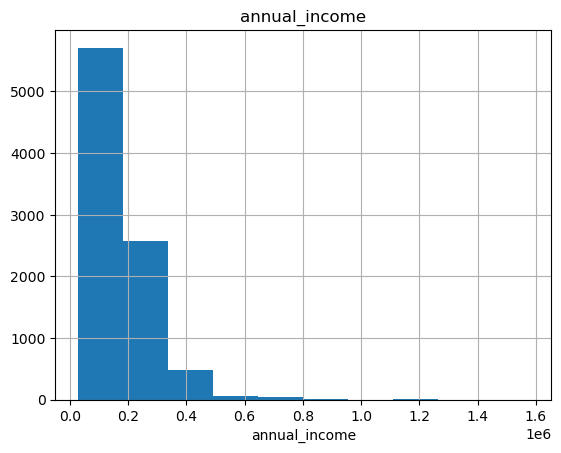

count     8876.000
mean    -16002.078
std       4255.667
min     -25152.000
5%      -23006.000
10%     -22000.000
20%     -20343.000
30%     -18765.500
40%     -17175.000
50%     -15671.000
60%     -14395.000
70%     -13083.500
80%     -11790.000
90%     -10397.000
95%      -9697.000
99%      -8522.250
max      -7705.000
Name: birthday, dtype: float64


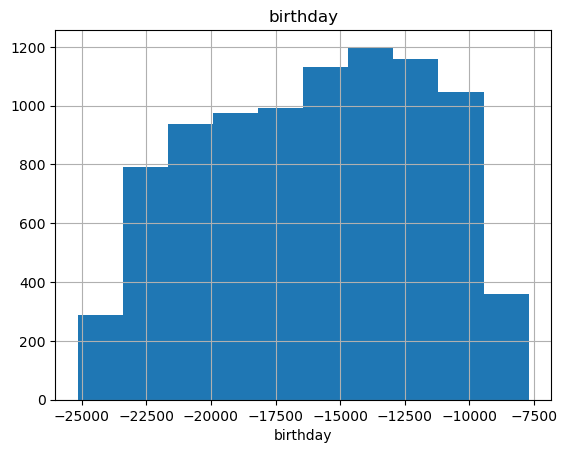

count     8876.000
mean     62205.606
std     140066.228
min     -15713.000
5%       -6913.500
10%      -5182.500
20%      -3458.000
30%      -2538.500
40%      -1860.000
50%      -1373.500
60%       -938.000
70%       -523.000
80%       -164.000
90%     365243.000
95%     365243.000
99%     365243.000
max     365243.000
Name: employment_date, dtype: float64


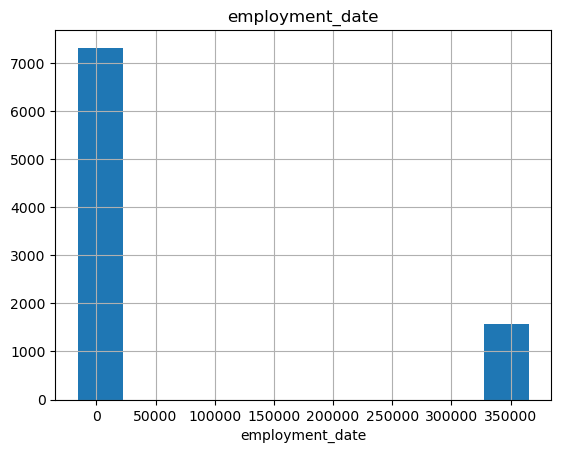

count   8876.000
mean     -27.585
std       16.630
min      -60.000
5%       -56.000
10%      -51.000
20%      -44.000
30%      -38.000
40%      -32.000
50%      -26.000
60%      -21.000
70%      -16.000
80%      -11.000
90%       -6.000
95%       -3.000
99%       -1.000
max        0.000
Name: tenure, dtype: float64


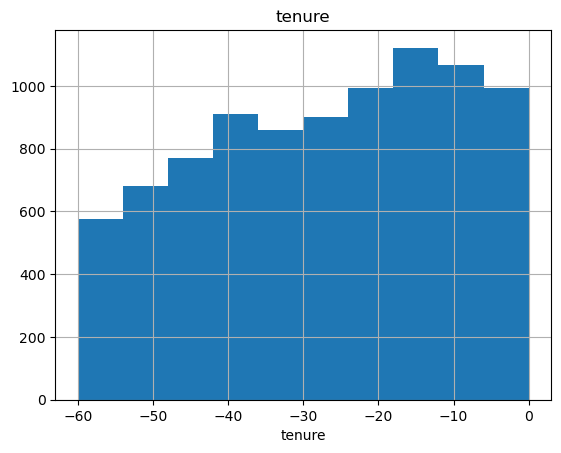

In [863]:
for col in num_cols:
    num_summary(df, col, plot=True)

In [864]:
for col in num_cols:
    target_summary_with_num(df, "risk", col)

      annual_income
risk               
0        179752.176
1        182183.008


       birthday
risk           
0    -16090.892
1    -15895.668


      employment_date
risk                 
0           63563.982
1           60578.111


      tenure
risk        
0    -32.415
1    -21.798




Almost none of the variables exhibit significant variation among each other. Therefore, there is a considerable need for feature extraction to elucidate causal effects.

##### Correlation Analysis

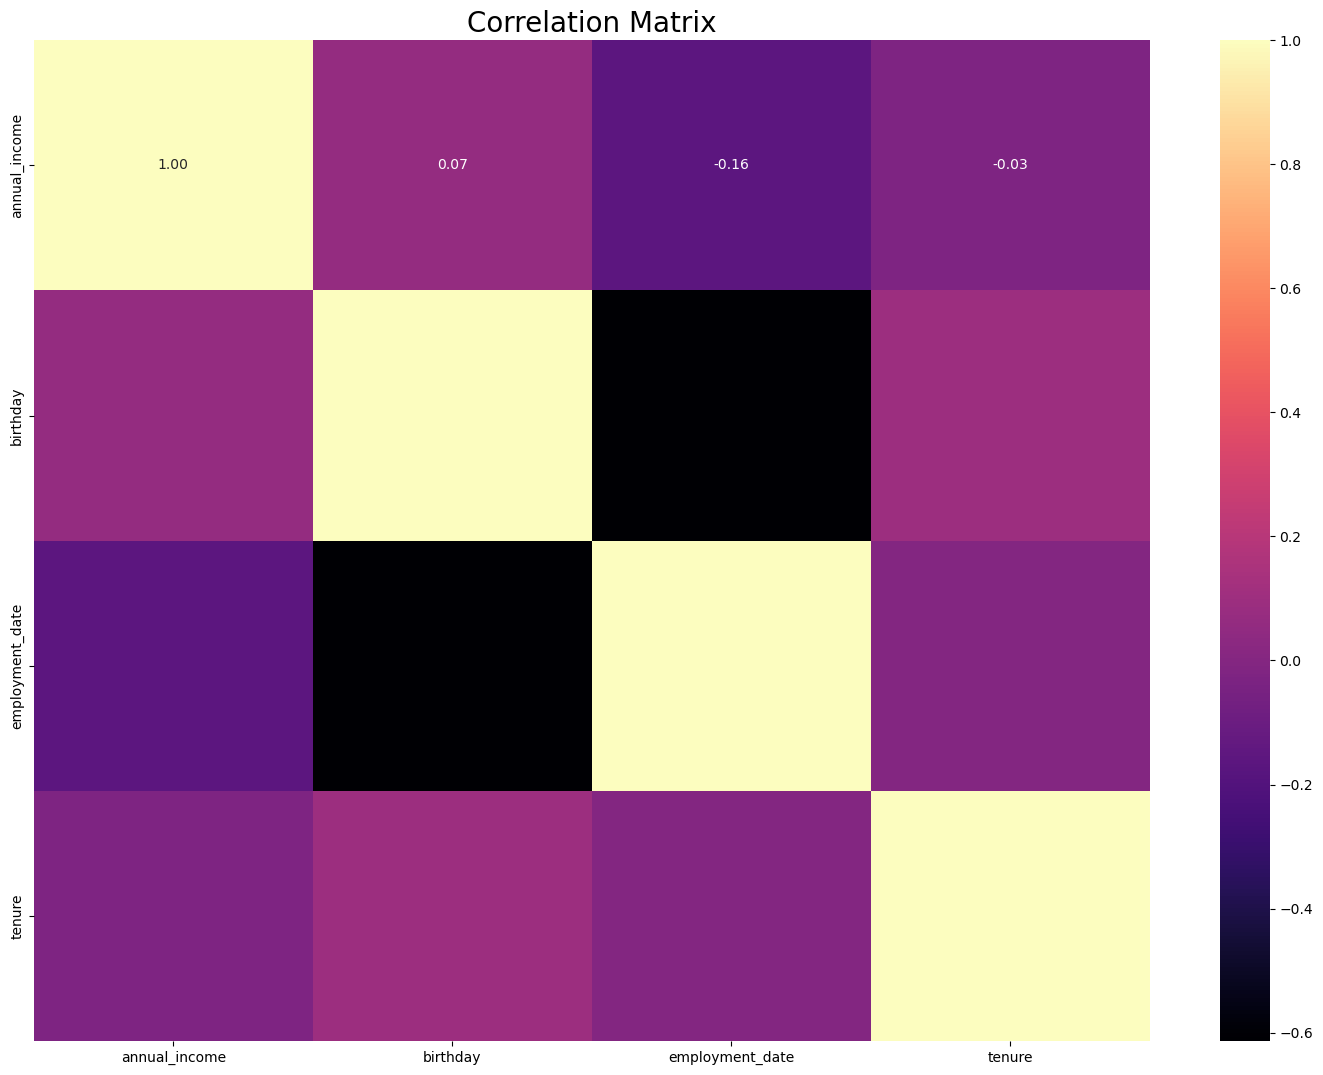

tenure             0.318
birthday           0.023
annual_income      0.012
employment_date   -0.011
dtype: float64


In [865]:
correlation_analysis(df, num_cols, "risk")

There is a negative correlation between "tenure" and "risk", which is the target variable, in this case, tenure would
be useful for detecting risky customers.

##### Data Preparation

Since there is no variation between observations regarding "own_mobile" variable, we drop "own_mobile".

In [866]:
df = df.drop(["ID", "own_mobile"], axis=1)

##### Missing Data Analysis

In [867]:
missing_values_table(df)

           n_miss  ratio
occu_type    2761 31.110


There are 2761 missing values in "occu_type".

##### Filling in missing data

In [868]:
df.loc[((df["occu_type"].isnull()) & (df["employment_date"] < 0)), "occu_type"] = "Unknown"

df.loc[((df["occu_type"].isnull()) & (df["employment_date"] > 0)), "occu_type"] = "Unemployed"

##### Feature Extraction/Interactions

Creating Age variable by Birthday variable

In [869]:
df["age"] = round((df["birthday"] / 365) * -1).astype(int)

Creating categorical age variable by "age"

In [870]:
bins = [df["age"].min(), 34, 45, 57, df["age"].max()]
labels = ["21-34", "35-45", "46-57", "58-69"]
df["age_category"] = pd.cut(df["age"], bins=bins, labels=labels, include_lowest=True)

Creating "experience" variable by "employment_date" variable

In [871]:
df["experience"] = round(df["employment_date"] / 30)

df["experience"] = df["experience"].apply(lambda x: int(x * -1) if x < 0 else 0)

Creating categorical experience variable from "experience" variable

In [872]:
def map_experience_to_category(experience):
    exp_by_year = experience / 12
    if 0 <= exp_by_year < 1:
        return "0-1 years_exp"
    elif 1 <= exp_by_year < 3:
        return "1-3 years_exp"
    elif 3 <= exp_by_year < 5:
        return "3-5 years_exp"
    elif 5 <= exp_by_year < 10:
        return "5-10 years_exp"
    elif 10 <= exp_by_year < 20:
        return "10-20 years_exp"
    else:
        return "20+ years_exp"

In [873]:
df["exp_category"] = df["experience"].apply(map_experience_to_category)

Creating occupation stage by "exp_category"

In [874]:
df.loc[(df["exp_category"] == "0-1 years_exp") |
       (df["exp_category"] == "1-3 years_exp") |
       (df["exp_category"] == "3-5 years_exp"), "occu_stage"] = "early_stage"

df.loc[(df["exp_category"] == "5-10 years_exp") |
       (df["exp_category"] == "10-20 years_exp"), "occu_stage"] = "mid_stage"

df.loc[(df["exp_category"] == "20+ years_exp"), "occu_stage"] = "late_stage"

Turning "tenure" into positive

In [875]:
df["tenure"] = df["tenure"] * -1

 Creating categorical tenure variable by "tenure"

In [876]:
def map_month_to_category(month):
    if 0 <= month < 6:
        return "0_6_customer"
    elif 6 <= month < 12:
        return "6_12_customer"
    elif 12 <= month < 24:
        return "12_24_customer"
    elif 24 <= month < 36:
        return "24_36_customer"
    elif 36 <= month < 48:
        return "36_48_customer"
    else:
        return "48+_customer"

In [877]:
df["cat_tenure"] = df["tenure"].apply(map_month_to_category)

In [878]:
df["cat_tenure"].value_counts()

cat_tenure
12_24_customer    2120
24_36_customer    1785
36_48_customer    1685
48+_customer      1392
6_12_customer     1080
0_6_customer       814
Name: count, dtype: int64

In [879]:
df.groupby("cat_tenure")["risk"].mean()

cat_tenure
0_6_customer     0.907
12_24_customer   0.443
24_36_customer   0.370
36_48_customer   0.322
48+_customer     0.292
6_12_customer    0.696
Name: risk, dtype: float64

Creating categorical income variable by "annual_income"

In [880]:
df["income_category"] = pd.qcut(df["annual_income"], q=4, labels=["low", "medium", "high", "very_high"])

Level-based Occupation Segmentation by "occu_type"

In [881]:
df.loc[(df['occu_type'] == 'Cleaning staff') |
       (df['occu_type'] == 'Cooking staff') |
       (df['occu_type'] == 'Drivers') | 
       (df['occu_type'] == 'Private service staff') |
       (df['occu_type'] == 'Laborers') |
       (df['occu_type'] == 'Security staff') |
       (df['occu_type'] == 'Waiters/barmen staff'), "level_based_occu"] = "labor_worker"

In [882]:
df.loc[(df['occu_type'] == 'Accountants') |
       (df['occu_type'] == 'HR staff') |
       (df['occu_type'] == 'Medicine staff') |
       (df['occu_type'] == 'Realty agents') |
       (df['occu_type'] == 'Sales staff') |
       (df['occu_type'] == 'Secretaries'), "level_based_occu"] = "office_worker"

In [883]:
df.loc[(df['occu_type'] == 'Managers') |
       (df['occu_type'] == 'High skill tech staff') |
       (df['occu_type'] == 'IT staff') |
       (df['occu_type'] == 'Core staff'), "level_based_occu"] = "high_worker"

In [884]:
df.loc[(df['occu_type'] == 'Unemployed'), "level_based_occu"] = "unemployed"

In [885]:
df.loc[(df['occu_type'] == 'Unknown'), "level_based_occu"] = "unknown"

Laborers

In [886]:
df.loc[(df["occu_type"] == "Laborers") | (df["occu_type"] == "Low-skill Laborers"), "occu_type"] = "Laborers"

Industry-based Occupation Segmentation by "occu_type"

In [887]:
df.loc[(df['occu_type'] == 'Cleaning staff') |
       (df['occu_type'] == 'Cooking staff') |
       (df['occu_type'] == 'Private service staff') |
       (df['occu_type'] == 'Waiters/barmen staff') |
       (df['occu_type'] == 'Medicine staff') |
       (df['occu_type'] == 'Drivers'), "ind_based_occu"] = "service_industry"

In [888]:
df.loc[(df['occu_type'] == 'Accountants') |
       (df['occu_type'] == 'HR staff') |
       (df['occu_type'] == 'Secretaries') |
       (df['occu_type'] == 'Core staff') |
       (df['occu_type'] == 'Managers') |
       (df['occu_type'] == 'Sales staff') |
       (df['occu_type'] == 'Security staff') |
       (df['occu_type'] == 'Realty agents'), "ind_based_occu"] = "pro_serv_industry"

In [889]:
df.loc[(df['occu_type'] == 'IT staff') |
       (df['occu_type'] == 'High skill tech staff'), "ind_based_occu"] = "tech_industry"

In [890]:
df.loc[(df['occu_type'] == 'Unemployed'), "ind_based_occu"] = "unemployed"

In [891]:
df.loc[(df['occu_type'] == 'Unknown'), "ind_based_occu"] = "unknown"

In [892]:
df.loc[(df['occu_type'] == 'Laborers'), "ind_based_occu"] = "laborers"

Creating categorical "active_worker" variable by "employment_date"

In [893]:
df["active_worker"] = df["employment_date"].apply(lambda x: 1 if x < 0 else 0)

Creating categorical "parent" variable by "num_child"

In [894]:
df["parent"] = df["num_child"].apply(lambda x: 0 if x == 0 else 1)

Creating categorical "life_stage" customer variable by "age"

In [895]:
df["life_stage"] = df["age"].apply(lambda x: "young" if x <= 25 else ("mature" if 25 < x <= 50 else "elder"))

Creating education segmentation by "education"

In [896]:
df.loc[(df["education"] == "Lower secondary") |
       (df["education"] == "Secondary / secondary special") |
       (df["education"] == "Incomplete higher"), "edu_segment"] = "low_edu"

In [897]:
df.loc[(df["education"] == "Higher education") | (df["education"] == "Academic degree"), "edu_segment"] = "high_edu"

Creating annual_income / family_size variable

In [898]:
df["income/fam_size"] = df["annual_income"] / df["family_size"]

##### Encoding

In [899]:
df1 = df.copy()

In [900]:
cat_cols, num_cols, cat_but_car = grab_col_names(df1, cat_th=20, car_th=45)

Observations: 8876
Variables: 32
cat_cols: 25
num_cols: 7
cat_but_car: 0
num_but_cat: 10


In [901]:
cat_cols = [col for col in cat_cols if col not in ["risk"]]

In [902]:
df1 = one_hot_encoder(df1, cat_cols, drop_first=True)

##### Checking for Outliers

In [903]:
for col in df1.columns:
    if df1[col].dtype == "category":
        df1[col] = df1[col].astype("O")
    else:
        pass

In [904]:
cat_cols, num_cols, cat_but_car = grab_col_names(df1, cat_th=20, car_th=45)

Observations: 8876
Variables: 98
cat_cols: 91
num_cols: 7
cat_but_car: 0
num_but_cat: 91


In [905]:
cat_cols = [col for col in cat_cols if col not in ["risk"]]

##### Local Outlier Factor (LOF) Method

In [906]:
clf = LocalOutlierFactor(n_neighbors=5)
clf.fit_predict(df1)

array([1, 1, 1, ..., 1, 1, 1])

In [907]:
df1_scores = clf.negative_outlier_factor_
df1_scores[0:5]
df1_scores = -df1_scores
np.sort(df1_scores)[0:5]
scores = pd.DataFrame(np.sort(df1_scores))

In [908]:
th = np.sort(df1_scores)[3]
df1[df1_scores < th]
df1[df1_scores < th].shape
df1.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T
df1[df1_scores < th].index

Index([694, 2516, 5425], dtype='int64')

In [909]:
df1 = df1[df1_scores > th]

There are 3 outliers

##### Modeling

In [910]:
y = df1["risk"]
X = df1.drop(["risk"], axis=1)

In [911]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [912]:
X_train = X_train.astype("float32")
y_train = y_train.astype("float32")
X_test = X_test.astype("float32")
y_test = y_test.astype("float32")

In [913]:
print(f"x_train shape: {X_train.shape}")
print(f"x_test shape: {X_test.shape}")

x_train shape: (7097, 97)
x_test shape: (1775, 97)


In [914]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

Reshape the arrays

In [915]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [916]:
X_train.shape
X_test.shape

(1775, 1, 97)

In [917]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(1, 97)),
    tf.keras.layers.Dense(units=64, activation="relu", name="hidden_layer"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation="sigmoid", name="output_layer")])

In [918]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, verbose=1, mode="min"),
    ModelCheckpoint(filepath="class_model.h5", monitor="val_loss", mode="min",
                    save_best_only=True, save_weights_only=False, verbose=1)]

In [919]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "accuracy"])

In [920]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 97)                0         
                                                                 
 hidden_layer (Dense)        (None, 64)                6272      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 6337 (24.75 KB)
Trainable params: 6337 (24.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [921]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/50
210/222 [===========================>..] - ETA: 0s - loss: 4225.0806 - precision_10: 0.4610 - recall_10: 0.4451 - accuracy: 0.5107
Epoch 1: val_loss improved from inf to 443.58331, saving model to class_model.h5
222/222 [==============================] - 1s 2ms/step - loss: 4137.6807 - precision_10: 0.4599 - recall_10: 0.4494 - accuracy: 0.5094 - val_loss: 443.5833 - val_precision_10: 0.4121 - val_recall_10: 0.1597 - val_accuracy: 0.5138
Epoch 2/50
155/222 [===================>..........] - ETA: 0s - loss: 1881.6034 - precision_10: 0.4383 - recall_10: 0.4370 - accuracy: 0.4917

209/222 [===========================>..] - ETA: 0s - loss: 1675.7030 - precision_10: 0.4455 - recall_10: 0.4414 - accuracy: 0.4952
Epoch 2: val_loss improved from 443.58331 to 245.91071, saving model to class_model.h5
222/222 [==============================] - 0s 1ms/step - loss: 1640.4125 - precision_10: 0.4467 - recall_10: 0.4426 - accuracy: 0.4970 - val_loss: 245.9107 - val_precision_10: 0.4078 - val_recall_10: 0.0520 - val_accuracy: 0.5341
Epoch 3/50
211/222 [===========================>..] - ETA: 0s - loss: 498.7758 - precision_10: 0.4551 - recall_10: 0.4552 - accuracy: 0.5064
Epoch 3: val_loss improved from 245.91071 to 86.56853, saving model to class_model.h5
222/222 [==============================] - 0s 2ms/step - loss: 487.0212 - precision_10: 0.4568 - recall_10: 0.4552 - accuracy: 0.5058 - val_loss: 86.5685 - val_precision_10: 0.4564 - val_recall_10: 0.6213 - val_accuracy: 0.4907
Epoch 4/50
212/222 [===========================>..] - ETA: 0s - loss: 122.1306 - precision_10: 0.

In [924]:
loss, precision, recall, acc = model.evaluate(X_test, y_test, verbose=False)

print("\nTest Accuracy: %.1f%%" % (100.0 * acc))
print("\nTest Precision: %.1f%%" % (100.0 * precision))
print("\nTest Recall: %.1f%%" % (100.0 * recall))
print("\nTest F1: %.3f%%" % (2 * (precision * recall) / (precision + recall)))


Test Accuracy: 45.7%

Test Precision: 45.6%

Test Recall: 99.5%

Test F1: 0.625%


##### Model Success Evaluation

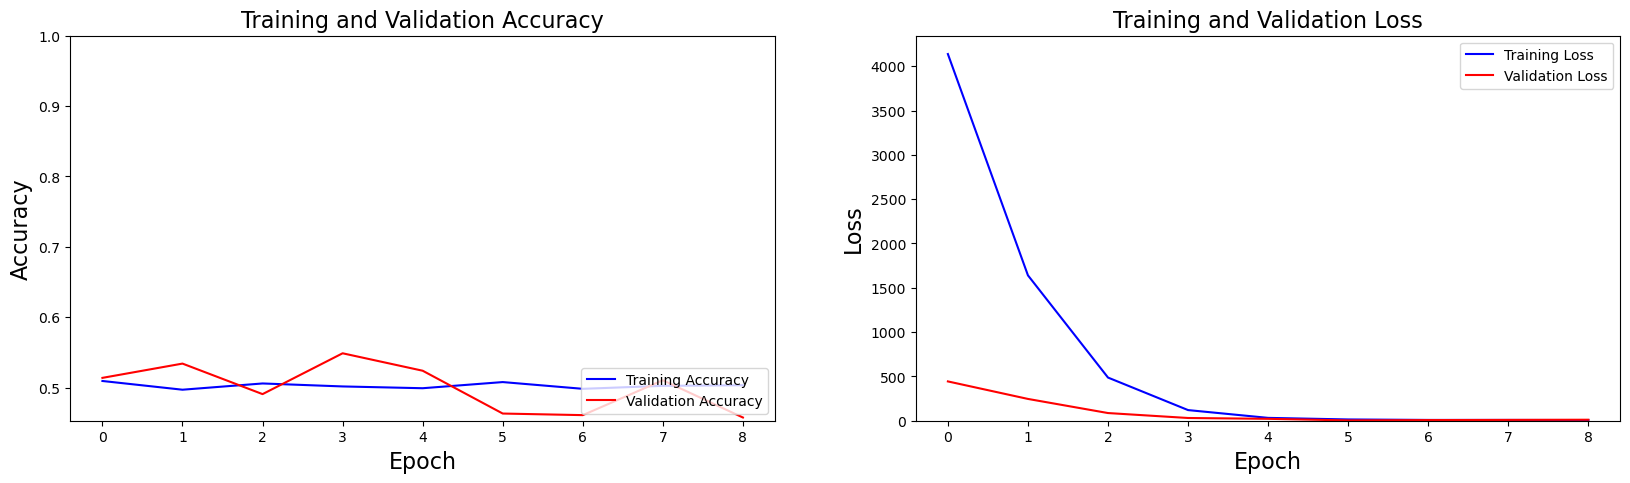

In [923]:
#---------------------
# Accuracy
# ---------------------
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color="b", label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color="r", label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy', fontsize=16)

#-------------------------
#Loss
# --------------------------
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color="b", label='Training Loss')
plt.plot(history.history['val_loss'], color="r", label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()